<a href="https://colab.research.google.com/github/sur-sakthy/computer-vision/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #1

In [1]:
!nvidia-smi

Tue Mar 21 07:59:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp '/content/drive/MyDrive/EE544 Computer Vision/imagenette2-160.tgz' ./

In [4]:
# remove %%capture command to show output from unzipping
%%capture 
!tar zxvf /content/imagenette2-160.tgz

## Imports

In [5]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, AUC, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

## Constants

In [6]:
PATH_TO_TRAIN_DATA = '/content/imagenette2-160/train'
PATH_TO_VAL_DATA = '/content/imagenette2-160/val'

IMG_WIDTH=64
IMG_HEIGHT=64

NUM_CLASSES=4

In [7]:
all_classes = os.listdir(PATH_TO_TRAIN_DATA)
all_classes

['n03028079',
 'n03000684',
 '.DS_Store',
 'n03417042',
 'n02979186',
 'n01440764',
 'n03425413',
 'n03445777',
 'n03888257',
 'n03394916',
 'n02102040']

In [8]:
all_classes = os.listdir(PATH_TO_VAL_DATA)
all_classes

['n03028079',
 'n03000684',
 'n03417042',
 'n02979186',
 'n01440764',
 'n03425413',
 'n03445777',
 'n03888257',
 'n03394916',
 'n02102040']

## Load dataset

In [9]:
data = []
labels = []

In [10]:
def load_dataset(img_folder): 
    for dir in os.listdir(img_folder):
      if dir == 'n03445777' or dir == 'n03417042' or dir == 'n02979186' or dir == 'n03028079' :
        for file in os.listdir(os.path.join(img_folder, dir)):
            image_path = os.path.join(img_folder, dir, file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
            image = np.array(image)

            data.append(image)
            labels.append(dir)

In [11]:
load_dataset(PATH_TO_TRAIN_DATA)
load_dataset(PATH_TO_VAL_DATA)

In [12]:
np.unique(labels)

array(['n02979186', 'n03028079', 'n03417042', 'n03445777'], dtype='<U9')

In [13]:
data[0]

array([[[  1,   0,   0],
        [ 16,  16,  16],
        [ 17,  18,  20],
        ...,
        [ 18,  19,  14],
        [ 19,  18,  14],
        [  0,   0,   0]],

       [[ 18,  18,  18],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 253],
        [255, 255, 253],
        [ 13,  13,  13]],

       [[ 28,  28,  28],
        [245, 245, 245],
        [255, 255, 253],
        ...,
        [255, 254, 255],
        [255, 254, 255],
        [ 20,  20,  20]],

       ...,

       [[ 28,  28,  28],
        [245, 245, 245],
        [254, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [ 19,  19,  19]],

       [[ 18,  18,  18],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [245, 245, 245],
        [252, 252, 250],
        [ 16,  16,  16]],

       [[  0,   1,   0],
        [ 16,  16,  16],
        [ 19,  17,  18],
        ...,
        [ 21,  21,  19],
        [ 16,  16,  14],
        [  0,   0,   0]]

## Split
Experimenting with the following splits:

Training/Validation/Test:
- 80/10/10
- 60/30/10
- 70/20/10


In [14]:
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.40, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=42)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

## Class distribution

In [17]:
df_train = pd.DataFrame(y_train, columns=['label'])
df_train.head()

,label
0,n02979186
1,n03028079
2,n03028079
3,n02979186
4,n03445777


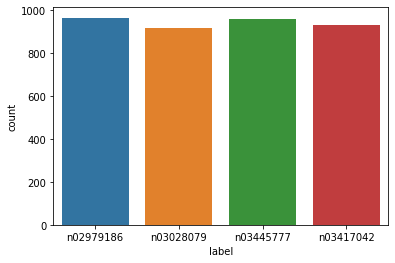

In [18]:
sns.countplot(data=df_train, x='label')
plt.show()

In [19]:
df_test = pd.DataFrame(y_test, columns=['label'])
df_test.head()

,label
0,n02979186
1,n03028079
2,n03417042
3,n03417042
4,n03028079


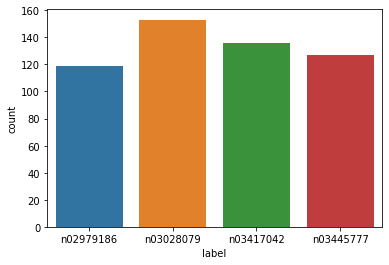

In [20]:
sns.countplot(data=df_test, x='label')
plt.show()

In [21]:
df_val = pd.DataFrame(y_val, columns=['label'])
df_val.head()

,label
0,n02979186
1,n03445777
2,n02979186
3,n03417042
4,n02979186


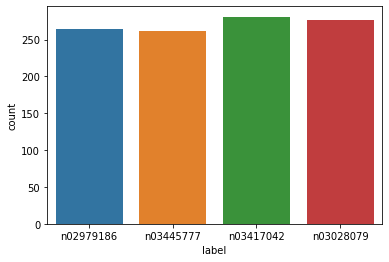

In [22]:
sns.countplot(data=df_val, x='label')
plt.show()

## Encoding

In [23]:
def one_hot_encode(y, num_classes):
  le = LabelEncoder()
  return to_categorical(le.fit_transform(y), num_classes)

In [24]:
y_train[0]

'n02979186'

In [25]:
y_train = one_hot_encode(y_train, NUM_CLASSES)

In [26]:
y_train[0]

array([1., 0., 0., 0.], dtype=float32)

In [27]:
y_test[0]

'n02979186'

In [28]:
y_test = one_hot_encode(y_test, NUM_CLASSES)

In [29]:
y_test[0]

array([1., 0., 0., 0.], dtype=float32)

In [30]:
np.array(y_train).shape

(3780, 4)

In [31]:
y_val[0]

'n02979186'

In [32]:
y_val = one_hot_encode(y_val, NUM_CLASSES)

In [33]:
y_val

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

## Create train, validation and test sets

In [34]:
train_datagen = ImageDataGenerator(        
        rescale=1./255,
        fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# data augmented training data
train_aug_datagen = ImageDataGenerator(        
        rescale=1./255,
        fill_mode="nearest",
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
)

In [35]:
train_ds = train_datagen.flow(
  np.array(X_train), y_train,
  shuffle=True,
  batch_size=128
)

train_aug_ds = train_datagen.flow(
  np.array(X_train), y_train,
  shuffle=True,
  batch_size=128
)

val_ds = val_datagen.flow(
  np.array(X_val), y_val,
  shuffle=True,
  batch_size=128
)

test_ds = test_datagen.flow(
  np.array(X_test), y_test,
  shuffle=False,
  batch_size=128
)

In [36]:
print('Shape of training samples: ', train_ds.x.shape)
print('Shape of validation samples: ', val_ds.x.shape)
print('Shape of test samples: ', test_ds.x.shape)

print('--------------------------')
print('Shape of augmented training samples: ', train_ds.x.shape)

Shape of training samples:  (3780, 64, 64, 3)
Shape of validation samples:  (1085, 64, 64, 3)
Shape of test samples:  (535, 64, 64, 3)
--------------------------
Shape of augmented training samples:  (3780, 64, 64, 3)


## Build model

In [37]:
def build_model(batchNorm=False, dropOut=False, l2Reg=False):
  model = Sequential()

  if l2Reg:
    model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer='l2', input_shape=(64,64,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer='l2'))
  else:
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(64,64,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))

  if batchNorm:
    model.add(BatchNormalization())

  if l2Reg:
    model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer='l2'))
    model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_regularizer='l2'))
  else:
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))

  if batchNorm:
    model.add(BatchNormalization())

  model.add(Flatten())

  if l2Reg:
    model.add(Dense(512, kernel_regularizer='l2'))
  else:
    model.add(Dense(512))
  
  if dropOut:
    model.add(Dropout(0.5))

  if l2Reg:
    model.add(Dense(NUM_CLASSES, activation='softmax', kernel_regularizer='l2'))
  else:
    model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.compile(
      optimizer=Adam(),
      loss='categorical_crossentropy',
      metrics=[
          CategoricalAccuracy(),
          Precision(), 
          Recall(),
          AUC()
        ]
  )

  return model

In [38]:
baseline_model = build_model()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                    

## Train model

### Initialise callbacks

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=2)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/EE544 Computer Vision/task-1-weights.hdf5', verbose=1, save_best_only=True, monitor='val_categorical_accuracy')

### Fit the model

In [40]:
baseline_history = baseline_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/30
29/30 [============================>.] - ETA: 0s - loss: 1.3437 - categorical_accuracy: 0.4491 - precision: 0.5852 - recall: 0.1476 - auc: 0.6937
Epoch 1: val_categorical_accuracy improved from -inf to 0.59078, saving model to /content/drive/MyDrive/EE544 Computer Vision/task-1-weights.hdf5
30/30 [==============================] - 18s 160ms/step - loss: 1.3303 - categorical_accuracy: 0.4550 - precision: 0.5959 - recall: 0.1537 - auc: 0.6997 - val_loss: 0.9701 - val_categorical_accuracy: 0.5908 - val_precision: 0.7491 - val_recall: 0.3714 - val_auc: 0.8427
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 0.8271 - categorical_accuracy: 0.6675 - precision: 0.7591 - recall: 0.5627 - auc: 0.8833
Epoch 2: val_categorical_accuracy improved from 0.59078 to 0.70599, saving model to /content/drive/MyDrive/EE544 Computer Vision/task-1-weights.hdf5
30/30 [==============================] - 2s 59ms/step - loss: 0.8271 - categorical_accuracy: 0.6675 - precision: 0.7591 -

## Plot results

In [41]:
def plot(train, validation, ylabel, title):
  plt.plot(train, color='red', label='train') 
  plt.plot(validation, color='blue', label='validation') 
  plt.title(title) 
  plt.ylabel(ylabel)
  plt.xlabel('Epoch')
  plt.legend() 
  plt.grid(linestyle='-', linewidth=0.5)

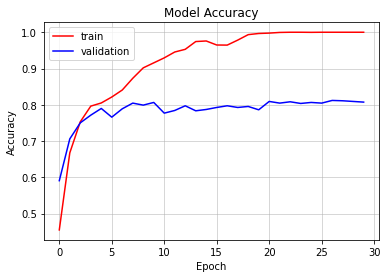

In [42]:
plot(baseline_history.history['categorical_accuracy'], baseline_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

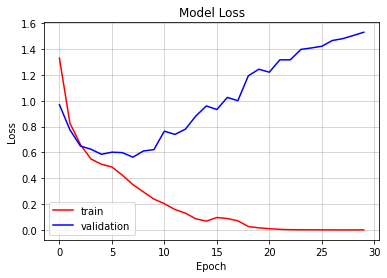

In [43]:
plot(baseline_history.history['loss'], baseline_history.history['val_loss'], 'Loss', 'Model Loss')

## Evaluate model

In [44]:
def evaluate_and_predict(model): 
  # evaluate on test dataset
  eval_results = model.evaluate(test_ds, batch_size=30)

  # print evaluation results
  print('Test loss:', eval_results[0])
  print('Test categorical_accuracy:', eval_results[1])
  print('Test precision:', eval_results[2])
  print('Test recall:', eval_results[3])
  print('Test auc:', eval_results[4])

  # predict
  return model.predict(test_ds)

In [45]:
pred = evaluate_and_predict(baseline_model)

5/5 [==============================] - 0s 41ms/step - loss: 1.4735 - categorical_accuracy: 0.8187 - precision: 0.8187 - recall: 0.8187 - auc: 0.9196
Test loss: 1.4735220670700073
Test categorical_accuracy: 0.818691611289978
Test precision: 0.818691611289978
Test recall: 0.818691611289978
Test auc: 0.9195655584335327
5/5 [==============================] - 0s 12ms/step


In [46]:
pred

array([[6.8085492e-02, 2.5010774e-01, 4.4164355e-04, 6.8136513e-01],
       [2.5547839e-09, 5.2474421e-03, 9.9475253e-01, 6.7188251e-09],
       [2.6731756e-01, 8.2338899e-02, 5.4839516e-01, 1.0194841e-01],
       ...,
       [5.7329452e-03, 9.9426514e-01, 9.4499271e-08, 1.8122397e-06],
       [1.0000000e+00, 1.1639106e-25, 1.5850429e-11, 2.2722995e-13],
       [7.3203657e-14, 1.0000000e+00, 1.7020231e-09, 5.5026117e-08]],
      dtype=float32)

In [47]:
def draw_confusion_matrix(true, pred):
  cm = confusion_matrix(true.argmax(axis=1), pred.argmax(axis=1))
  sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g', cbar=False, cmap="viridis")
  plt.show()

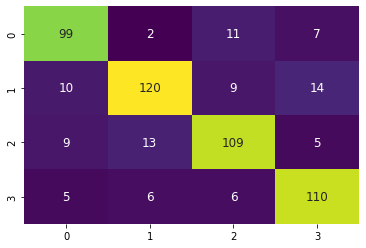

In [48]:
draw_confusion_matrix(y_test, pred)

In [49]:
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       119
           1       0.85      0.78      0.82       153
           2       0.81      0.80      0.80       136
           3       0.81      0.87      0.84       127

    accuracy                           0.82       535
   macro avg       0.82      0.82      0.82       535
weighted avg       0.82      0.82      0.82       535



## Improve the baseline networks performance
1. Batch Normalisation 
2. Dropout 
3. Data Augmentation
4. Regularisation

### Batch Normalisation

In [50]:
batchnorm_model = build_model(batchNorm=True)
batchnorm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 64)       

In [51]:
batchnorm_history = batchnorm_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
30/30 [==============================] - 4s 51ms/step - loss: 5.4950 - categorical_accuracy: 0.6045 - precision_1: 0.6072 - recall_1: 0.6008 - auc_1: 0.7801 - val_loss: 1.3914 - val_categorical_accuracy: 0.2949 - val_precision_1: 0.4545 - val_recall_1: 0.0184 - val_auc_1: 0.5835
Epoch 2/30
30/30 [==============================] - 1s 37ms/step - loss: 1.5094 - categorical_accuracy: 0.7913 - precision_1: 0.7934 - recall_1: 0.7884 - auc_1: 0.9125 - val_loss: 1.6294 - val_categorical_accuracy: 0.2885 - val_precision_1: 0.3426 - val_recall_1: 0.1475 - val_auc_1: 0.5807
Epoch 3/30
30/30 [==============================] - 1s 38ms/step - loss: 0.6089 - categorical_accuracy: 0.8667 - precision_1: 0.8696 - recall_1: 0.8646 - auc_1: 0.9646 - val_loss: 1.4623 - val_categorical_accuracy: 0.3493 - val_precision_1: 0.7226 - val_recall_1: 0.0912 - val_auc_1: 0.6074
Epoch 4/30
30/30 [==============================] - 1s 38ms/step - loss: 0.2454 - categorical_accuracy: 0.9347 - precision_1: 0

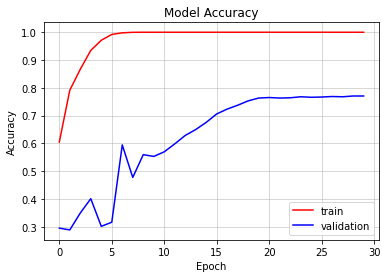

In [52]:
plot(batchnorm_history.history['categorical_accuracy'], batchnorm_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

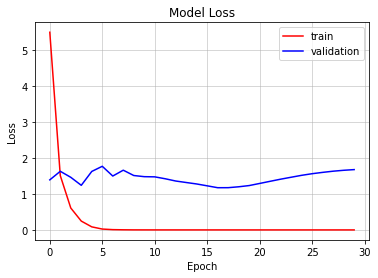

In [53]:
plot(batchnorm_history.history['loss'], batchnorm_history.history['val_loss'], 'Loss', 'Model Loss')

In [54]:
batchnorm_pred = evaluate_and_predict(batchnorm_model)

5/5 [==============================] - 0s 14ms/step - loss: 1.6161 - categorical_accuracy: 0.7664 - precision_1: 0.7692 - recall_1: 0.7664 - auc_1: 0.9010
Test loss: 1.6161214113235474
Test categorical_accuracy: 0.7663551568984985
Test precision: 0.7692307829856873
Test recall: 0.7663551568984985
Test auc: 0.9010434746742249
5/5 [==============================] - 0s 11ms/step


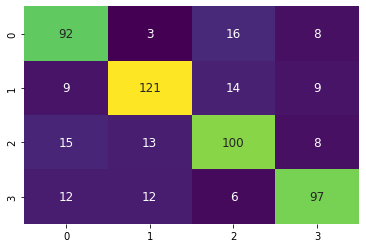

In [55]:
draw_confusion_matrix(y_test, batchnorm_pred)

In [56]:
print(classification_report(y_test.argmax(axis=1), batchnorm_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       119
           1       0.81      0.79      0.80       153
           2       0.74      0.74      0.74       136
           3       0.80      0.76      0.78       127

    accuracy                           0.77       535
   macro avg       0.77      0.77      0.77       535
weighted avg       0.77      0.77      0.77       535



### Dropout

In [57]:
dropout_model = build_model(dropOut=True)
dropout_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                  

In [58]:
dropout_history = dropout_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/30
30/30 [==============================] - 4s 62ms/step - loss: 1.3618 - categorical_accuracy: 0.4659 - precision_2: 0.6079 - recall_2: 0.1870 - auc_2: 0.7092 - val_loss: 0.9326 - val_categorical_accuracy: 0.6166 - val_precision_2: 0.7062 - val_recall_2: 0.4230 - val_auc_2: 0.8551
Epoch 2/30
30/30 [==============================] - 1s 38ms/step - loss: 0.8230 - categorical_accuracy: 0.6751 - precision_2: 0.7479 - recall_2: 0.5587 - auc_2: 0.8852 - val_loss: 0.7204 - val_categorical_accuracy: 0.7309 - val_precision_2: 0.7960 - val_recall_2: 0.6184 - val_auc_2: 0.9140
Epoch 3/30
30/30 [==============================] - 1s 37ms/step - loss: 0.6367 - categorical_accuracy: 0.7619 - precision_2: 0.8132 - recall_2: 0.7003 - auc_2: 0.9317 - val_loss: 0.6993 - val_categorical_accuracy: 0.7318 - val_precision_2: 0.7802 - val_recall_2: 0.6839 - val_auc_2: 0.9184
Epoch 4/30
30/30 [==============================] - 1s 36ms/step - loss: 0.5910 - categorical_accuracy: 0.7799 - precision_2: 0

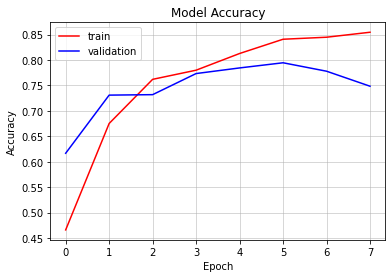

In [59]:
plot(dropout_history.history['categorical_accuracy'], dropout_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

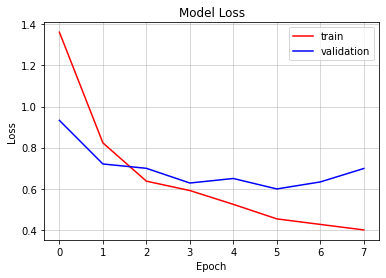

In [60]:
plot(dropout_history.history['loss'], dropout_history.history['val_loss'], 'Loss', 'Model Loss')

In [61]:
dropout_pred = evaluate_and_predict(dropout_model)

5/5 [==============================] - 0s 13ms/step - loss: 0.6876 - categorical_accuracy: 0.7607 - precision_2: 0.7864 - recall_2: 0.7364 - auc_2: 0.9252
Test loss: 0.687620997428894
Test categorical_accuracy: 0.7607476711273193
Test precision: 0.7864271402359009
Test recall: 0.7364485859870911
Test auc: 0.9251911044120789
5/5 [==============================] - 0s 10ms/step


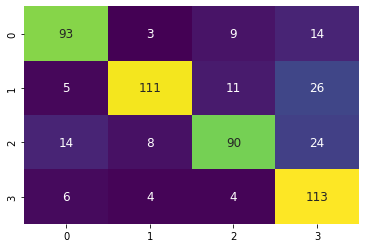

In [62]:
draw_confusion_matrix(y_test, dropout_pred)

In [63]:
print(classification_report(y_test.argmax(axis=1), dropout_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       119
           1       0.88      0.73      0.80       153
           2       0.79      0.66      0.72       136
           3       0.64      0.89      0.74       127

    accuracy                           0.76       535
   macro avg       0.77      0.76      0.76       535
weighted avg       0.78      0.76      0.76       535



### Data Augmentation

In [64]:
dataaug_model = build_model()
dataaug_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                  

In [65]:
dataaug_history = dataaug_model.fit(
    train_aug_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
30/30 [==============================] - 5s 49ms/step - loss: 1.4024 - categorical_accuracy: 0.4101 - precision_3: 0.5441 - recall_3: 0.1354 - auc_3: 0.6795 - val_loss: 0.9847 - val_categorical_accuracy: 0.5862 - val_precision_3: 0.6919 - val_recall_3: 0.3622 - val_auc_3: 0.8375
Epoch 2/30
30/30 [==============================] - 1s 37ms/step - loss: 0.8447 - categorical_accuracy: 0.6677 - precision_3: 0.7557 - recall_3: 0.5312 - auc_3: 0.8788 - val_loss: 0.7741 - val_categorical_accuracy: 0.7041 - val_precision_3: 0.7568 - val_recall_3: 0.6111 - val_auc_3: 0.9006
Epoch 3/30
30/30 [==============================] - 1s 37ms/step - loss: 0.6421 - categorical_accuracy: 0.7519 - precision_3: 0.8033 - recall_3: 0.6873 - auc_3: 0.9301 - val_loss: 0.6914 - val_categorical_accuracy: 0.7438 - val_precision_3: 0.8013 - val_recall_3: 0.6876 - val_auc_3: 0.9216
Epoch 4/30
30/30 [==============================] - 1s 37ms/step - loss: 0.5778 - categorical_accuracy: 0.7828 - precision_3: 0

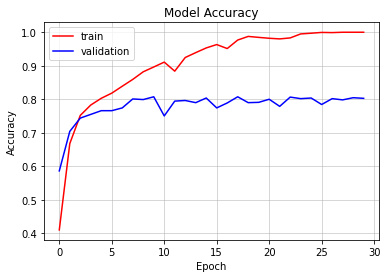

In [66]:
plot(dataaug_history.history['categorical_accuracy'], dataaug_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

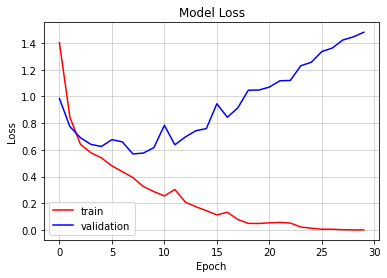

In [67]:
plot(dataaug_history.history['loss'], dataaug_history.history['val_loss'], 'Loss', 'Model Loss')

In [68]:
dataaug_pred = evaluate_and_predict(dataaug_model)

5/5 [==============================] - 0s 19ms/step - loss: 1.5867 - categorical_accuracy: 0.7869 - precision_3: 0.7895 - recall_3: 0.7850 - auc_3: 0.9129
Test loss: 1.5866658687591553
Test categorical_accuracy: 0.7869158983230591
Test precision: 0.7894737124443054
Test recall: 0.7850467562675476
Test auc: 0.9128722548484802
5/5 [==============================] - 0s 13ms/step


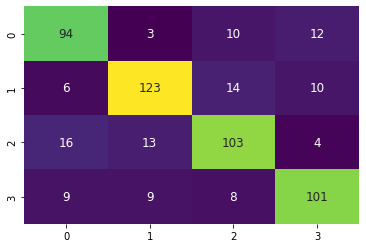

In [69]:
draw_confusion_matrix(y_test, dataaug_pred)

In [70]:
print(classification_report(y_test.argmax(axis=1), dataaug_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       119
           1       0.83      0.80      0.82       153
           2       0.76      0.76      0.76       136
           3       0.80      0.80      0.80       127

    accuracy                           0.79       535
   macro avg       0.79      0.79      0.79       535
weighted avg       0.79      0.79      0.79       535



### L2 Regularisation

In [71]:
l2reg_model = build_model(l2Reg=True)
l2reg_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                  

In [72]:
l2reg_history = l2reg_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
30/30 [==============================] - 4s 49ms/step - loss: 6.0192 - categorical_accuracy: 0.3601 - precision_4: 0.4368 - recall_4: 0.0603 - auc_4: 0.6212 - val_loss: 2.7831 - val_categorical_accuracy: 0.4876 - val_precision_4: 0.6553 - val_recall_4: 0.1594 - val_auc_4: 0.7406
Epoch 2/30
30/30 [==============================] - 1s 37ms/step - loss: 2.2064 - categorical_accuracy: 0.5185 - precision_4: 0.6686 - recall_4: 0.2481 - auc_4: 0.7659 - val_loss: 1.7917 - val_categorical_accuracy: 0.5263 - val_precision_4: 0.6453 - val_recall_4: 0.2968 - val_auc_4: 0.7923
Epoch 3/30
30/30 [==============================] - 1s 36ms/step - loss: 1.6358 - categorical_accuracy: 0.5870 - precision_4: 0.6925 - recall_4: 0.3706 - auc_4: 0.8225 - val_loss: 1.5392 - val_categorical_accuracy: 0.5843 - val_precision_4: 0.6837 - val_recall_4: 0.4323 - val_auc_4: 0.8382
Epoch 4/30
30/30 [==============================] - 1s 36ms/step - loss: 1.4291 - categorical_accuracy: 0.6413 - precision_4: 0

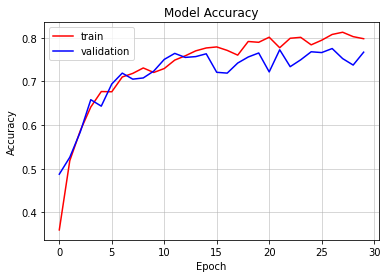

In [73]:
plot(l2reg_history.history['categorical_accuracy'], l2reg_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

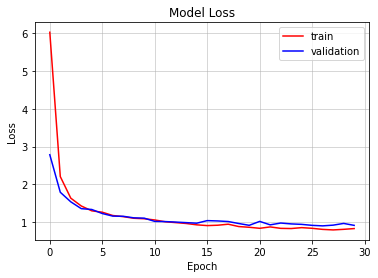

In [74]:
plot(l2reg_history.history['loss'], l2reg_history.history['val_loss'], 'Loss', 'Model Loss')

In [75]:
l2reg_pred = evaluate_and_predict(l2reg_model)

5/5 [==============================] - 0s 17ms/step - loss: 0.9321 - categorical_accuracy: 0.7664 - precision_4: 0.8056 - recall_4: 0.6972 - auc_4: 0.9254
Test loss: 0.9320512413978577
Test categorical_accuracy: 0.7663551568984985
Test precision: 0.8056155443191528
Test recall: 0.6971962451934814
Test auc: 0.9254415035247803
5/5 [==============================] - 0s 16ms/step


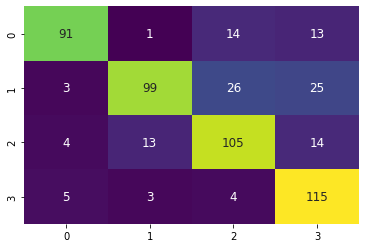

In [76]:
draw_confusion_matrix(y_test, l2reg_pred)

In [77]:
print(classification_report(y_test.argmax(axis=1), l2reg_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82       119
           1       0.85      0.65      0.74       153
           2       0.70      0.77      0.74       136
           3       0.69      0.91      0.78       127

    accuracy                           0.77       535
   macro avg       0.78      0.77      0.77       535
weighted avg       0.78      0.77      0.77       535

